In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

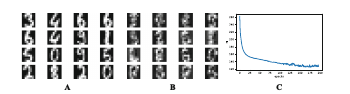

Fig.6 An example of outcomes after the training: (a) Randomly selected real images. (b) Unconditional generations from the RealNVP. (c) The validation curve during training.

## Is It All? Really?

Yes and no. Yes, in the sense that it is the minimalistic example of an implementation of the RealNVP. No, because there are many improvements over the instance of the RealNVP presented here, namely:

- **Factoring out** [7]: During the forward pass (from $ \mathbf{x} $ to $ \mathbf{z} $), we can split the variables and proceed with processing only a subset of them. This could help to parameterize the base distribution by using the outputs of intermediate layers. In other words, we can obtain an autoregressive base distribution.

  - **Fig.6**: An example of outcomes after the training:
    - (a) Randomly selected real images.
    - (b) Unconditional generations from the RealNVP.
    - (c) The validation curve during training.

- **Rezero trick** [11]: Introducing additional parameters to the coupling layer, e.g., 

  $$
  \mathbf{y}_b = \exp(\alpha s(\mathbf{x}_a)) \odot \mathbf{x}_b + \beta t(\mathbf{x}_a)
  $$

  where $ \alpha $ and $ \beta $ are initialized with 0’s. This helps to ensure that the transformations act as identity maps in the beginning. It is shown in [12] that this trick helps to learn better transformations by maintaining information about the input through all layers in the beginning of the training process.

- **Masking or Checkerboard pattern** [7]: We can use a checkerboard pattern instead of dividing an input into two parts like:

  $$
  [\mathbf{x}_{1:D/2}, \mathbf{x}_{D/2+1:D}]
  $$

  This encourages learning local statistics better.

- **Squeezing** [7]: We can also experiment with “squeezing” some dimensions. For instance, an image consists of $ C $ channels, width $ W $, and height $ H $, which could be turned into $ 4C $ channels, width $ W/2 $, and height $ H/2 $.

- **Learnable base distributions**: Instead of using a standard Gaussian base distribution, we can consider another model for that, e.g., an autoregressive model.

- **Invertible 1x1 convolution** [8]: A fixed permutation could be replaced with a (learned) invertible 1x1 convolution as in the GLOW model [8].

- **Variational dequantization** [13]: We can also pick a different dequantization scheme, e.g., variational dequantization. This allows for much better scores. However, it is not for free, because it leads to a lower bound to the log-likelihood function.

### Other Fascinating Research Directions

- **Data compression with flows** [14]: Flow-based models are perfect candidates for compression since they allow us to calculate the exact likelihood. [14] proposed a scheme that allows using flows in the bit-back-like compression scheme.

- **Conditional flows** [15–17]: Here, we present the unconditional RealNVP. However, we can use a flow-based model for conditional distributions. For instance, we can use the conditioning as an input to the scale network and the translation network.

- **Variational inference with flows** [1, 3, 18–21]: Conditional flow-based models could be used to form a flexible family of variational posteriors. Then, the lower bound to the log-likelihood function could be tighter. We will come back to that in Chapter 5, Section 5.4.2.

- **Integer discrete flows** [12, 22, 23]: Another interesting direction is a version of the RealNVP for integer-valued data. We will explain this idea in Section 4.2.

- **Flows on manifolds** [24]: Typically, flow-based models are considered in the Euclidean space. However, they could be considered in non-Euclidean spaces, resulting in new properties of (partially) invertible transformations.

- **Flows for ABC** [25]: Approximate Bayesian computation (ABC) assumes that the posterior over quantities of interest is intractable. One possible approach to mitigate this issue is to approximate it using flow-based models, e.g., masked autoregressive flows [26], as presented in [25].

  Much other interesting information on flow-based models could be found in a fantastic review by [27].


##  ResNet Flows and DenseNet Flows

###  ResNet Flows [4, 5]

In the previous sections, we discussed flow-based models with predesigned architectures (i.e., blocks consisting of coupling layers and permutation layers) that allow easy calculation of the Jacobian determinant. However, we can take a different approach and think of how we can approximate the Jacobian determinant for an almost arbitrary architecture. Additionally, we explore what kind of requirements must be imposed to make the architecture invertible.

In [4], the authors consider widely used residual neural networks (ResNets) and construct an invertible ResNet layer which is only constrained by Lipschitz continuity. A ResNet is defined as:

$$
\mathbf{F}(\mathbf{x}) = \mathbf{x} + g(\mathbf{x})
$$

where $ g $ is modeled by a (convolutional) neural network, and $ \mathbf{F} $ represents a ResNet layer, which is in general not invertible. However, $ g $ is constructed in such a way that it satisfies the Lipschitz constant being strictly lower than 1:

$$
\text{Lip}(g) < 1, \quad \text{if} \quad \| \mathbf{W}_i \|_2 < 1
$$

where $ \| \cdot \|_2 $ is the $ \ell_2 $-matrix norm. Then, we have:

$$
\text{Lip}(g) = K < 1 \quad \text{and} \quad \text{Lip}(\mathbf{F}) < 1 + K
$$

Only in this specific case, the Banach fixed-point theorem holds, and the ResNet layer $ \mathbf{F} $ has a unique inverse. As a result, the inverse can be approximated by fixed-point iterations [4].

Estimating the log determinant is, especially for high-dimensional spaces, computationally intractable due to expensive computations. Since ResNet blocks have a constrained Lipschitz constant, the logarithm of the Jacobian determinant is cheaper to compute, tractable, and can be approximated with guaranteed convergence:

$$
\ln p(\mathbf{x}) = \ln p(\mathbf{f}(\mathbf{x})) + \sum_{k=1}^{\infty} (-1)^{k+1} \, \text{tr} \left( \mathbf{J}_g(\mathbf{x})^k \right)
$$

where $ \mathbf{J}_g(\mathbf{x}) $ is the Jacobian of $ g $ at $ \mathbf{x} $, and $ \| \mathbf{J}_g \| < 1 $. The Skilling-Hutchinson trace estimator [30, 31] is used to compute the trace at a lower cost than fully computing the trace of the Jacobian.

Residual flows [5] use an improved method to estimate the power series at an even lower cost with an unbiased estimator based on “Russian roulette” [32]. Intuitively, the method estimates the infinite sum of the power series by evaluating a finite number of terms. In return, this leads to fewer computations compared to invertible residual networks.

To avoid derivative saturation, which occurs when the second derivative is zero in large regions, the **LipSwish** activation is proposed [4].


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm

# ResNet Block Definition
class ResNetBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ResNetBlock, self).__init__()

        # Define the layers of the ResNet block with spectral normalization applied
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Apply spectral normalization directly to the layers
        self.fc1 = spectral_norm(self.fc1)
        self.fc2 = spectral_norm(self.fc2)
        
        # Optional activation function (LipSwish in original work)
        self.activation = nn.Softplus()  # Using Softplus as a non-linear activation function
    
    def forward(self, x):
        # Define the forward pass
        residual = x
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        
        # Adding the residual (skip connection)
        return x + residual

# RealNVP with ResNet Flows
class RealNVPResNetFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows):
        super(RealNVPResNetFlow, self).__init__()

        self.num_flows = num_flows
        self.input_dim = input_dim

        # Define the ResNet blocks for the flow
        self.resnet_blocks = nn.ModuleList(
            [ResNetBlock(input_dim, hidden_dim, input_dim) for _ in range(num_flows)]
        )
    
    def coupling(self, x, block, forward=True):
        """ Coupling layer with ResNet transformation """
        mid = x.size(1) // 2  # Correct handling of dimensions
        xa, xb = x[:, :mid], x[:, mid:]

        # Apply ResNet transformation
        s, t = block(xa), block(xa)

        if forward:
            yb = (xb - t) * torch.exp(-s)
        else:
            yb = torch.exp(s) * xb + t

        return torch.cat([xa, yb], dim=-1)
    
    def forward(self, x):
        """ Forward pass through the normalizing flow model """
        log_det_J = 0
        z = x
        for i in range(self.num_flows):
            z = self.coupling(z, self.resnet_blocks[i], forward=True)
            log_det_J += torch.sum(z)  # A simple log determinant approximation
            
        return z, log_det_J

    def inverse(self, z):
        """ Inverse pass through the normalizing flow model """
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.coupling(x, self.resnet_blocks[i], forward=False)
        return x

# Define a simple prior (standard normal distribution)
class StandardNormalPrior(nn.Module):
    def forward(self, z):
        return -0.5 * torch.sum(z ** 2, dim=-1)

# Define the model and optimizer
input_dim = 4  # Adjust input dimension to match your data
hidden_dim = 128
num_flows = 8
model = RealNVPResNetFlow(input_dim, hidden_dim, num_flows)
prior = StandardNormalPrior()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop (dummy data)
num_epochs = 100
for epoch in range(num_epochs):
    # Dummy data (batch size of 16 and 4-dimensional input to match input_dim)
    x = torch.randn(16, input_dim)

    # Forward pass through the model
    z, log_det_J = model(x)

    # Calculate the log likelihood (negative log likelihood)
    log_prob = prior(z)
    loss = -(log_prob + log_det_J)

    # Backpropagate and optimize
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.mean().item():.4f}")

# Generate samples from the model
with torch.no_grad():
    z_samples = torch.randn(5, input_dim)  # 5 samples from the prior
    generated_samples = model.inverse(z_samples)
    print("Generated Samples:")
    print(generated_samples)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ResNet Block Definition
class ResNetBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ResNetBlock, self).__init__()

        # Define the layers of the ResNet block
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Optional activation function (ReLU or other)
        self.activation = nn.ReLU()

    def forward(self, x):
        # Define the forward pass
        residual = x
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        
        # Adding the residual (skip connection)
        return x + residual

# RealNVP with ResNet Flows
class RealNVPResNetFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows):
        super(RealNVPResNetFlow, self).__init__()

        self.num_flows = num_flows
        self.input_dim = input_dim

        # Define the ResNet blocks for the flow
        self.resnet_blocks = nn.ModuleList(
            [ResNetBlock(input_dim, hidden_dim, input_dim) for _ in range(num_flows)]
        )
    
    def coupling(self, x, block, forward=True):
        """ Coupling layer with ResNet transformation """
        mid = x.size(1) // 2  # Correct handling of dimensions
        xa, xb = x[:, :mid], x[:, mid:]

        # Apply ResNet transformation
        s, t = block(xa), block(xa)

        if forward:
            yb = (xb - t) * torch.exp(-s)
        else:
            yb = torch.exp(s) * xb + t

        return torch.cat([xa, yb], dim=-1)
    
    def forward(self, x):
        """ Forward pass through the normalizing flow model """
        log_det_J = 0
        z = x
        for i in range(self.num_flows):
            z = self.coupling(z, self.resnet_blocks[i], forward=True)
            log_det_J += torch.sum(z)  # A simple log determinant approximation
            
        return z, log_det_J

    def inverse(self, z):
        """ Inverse pass through the normalizing flow model """
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.coupling(x, self.resnet_blocks[i], forward=False)
        return x

# Define a simple prior (standard normal distribution)
class StandardNormalPrior(nn.Module):
    def forward(self, z):
        return -0.5 * torch.sum(z ** 2, dim=-1)

# Define the model and optimizer
input_dim = 4  # Adjust input dimension to match your data
hidden_dim = 128
num_flows = 8
model = RealNVPResNetFlow(input_dim, hidden_dim, num_flows)
prior = StandardNormalPrior()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop (dummy data)
num_epochs = 100
for epoch in range(num_epochs):
    # Dummy data (batch size of 16 and 4-dimensional input to match input_dim)
    x = torch.randn(16, input_dim)

    # Forward pass through the model
    z, log_det_J = model(x)

    # Calculate the log likelihood (negative log likelihood)
    log_prob = prior(z)
    loss = -(log_prob + log_det_J)

    # Backpropagate and optimize
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.mean().item():.4f}")

# Generate samples from the model
with torch.no_grad():
    z_samples = torch.randn(5, input_dim)  # 5 samples from the prior
    generated_samples = model.inverse(z_samples)
    print("Generated Samples:")
    print(generated_samples)
#doable

##  DenseNet Flows

Since it is possible to formulate a flow for a ResNet architecture, a natural question is whether it could be accomplished for densely connected networks (DenseNets) $[33]$. In $[6]$, it was shown that indeed it is possible!

The main component of DenseNet flows is a **DenseBlock** that is defined as a function $ F : \mathbb{R}^d \to \mathbb{R}^d $ with:

$$ F(x) = x + g(x), $$

where $ g $ consists of dense layers:

$$ g(x) = h_{n+1} \circ h_n \circ \dots \circ h_1(x), $$

where $ h_{n+1} $ represents a $ 1 \times 1 $ convolution to match the output size of $ \mathbb{R}^d $. A layer $ h_i $ consists of two parts concatenated to each other. The upper part is a copy of the input signal, and the lower part consists of the transformed input, where the transformation is a multiplication of (convolutional) weights $ W_i $ with the input signal, followed by a nonlinearity $ \phi $ having $ \text{Lip}(\phi) \leq 1 $, such as ReLU, ELU, LipSwish, or tanh.

As an example, a dense layer $ h_2 $ can be composed as follows:

$$
h_1(x) = \left[ x, \phi(W_1 x) \right], \quad h_2(h_1(x)) = \left[ \phi(W_2 h_1(x)), \phi(W_3 h_2(h_1(x))) \right].
$$

The DenseNet flows $[6]$ rely on the same techniques for approximating the Jacobian determinant as in the ResNet flows. The main difference between DenseNet flows and ResNet flows lies in normalizing weights, so that the Lipschitz constant of the transformation is smaller than 1, ensuring the transformation is invertible.

Formally, to satisfy $ \text{Lip}(g) < 1 $, we need to enforce $ \text{Lip}(h_i) < 1 $ for all $ n $ layers, since $ \text{Lip}(g) \leq \text{Lip}(h_{n+1}) \cdot \dots \cdot \text{Lip}(h_1) $. Therefore, we first need to determine the Lipschitz constant for a dense layer $ h_i $. We know that a function $ f $ is $ K $-Lipschitz if for all points $ v $ and $ w $, the following holds:

$$
d_Y(f(v), f(w)) \leq K \cdot d_X(v, w),
$$

where we assume that the distance metrics $ d_X = d_Y = d $ are chosen to be the $ \ell_2 $-norm. Further, let two functions $ f_1 $ and $ f_2 $ be concatenated in $ h $:

$$
h_v = \left[ f_1(v), f_2(v) \right], \quad h_w = \left[ f_1(w), f_2(w) \right].
$$

We can now find an analytical form to express a limit on $ K $ for the dense layer in the form of Equation (4.27):

$$
d(h_v, h_w)^2 = d(f_1(v), f_1(w))^2 + d(f_2(v), f_2(w))^2.
$$

Thus, the Lipschitz constant of layer $ h $ can be expressed as:

$$
\text{Lip}(h) = \sqrt{\text{Lip}(f_1)^2 + \text{Lip}(f_2)^2}.
$$

With spectral normalization of Equation (4.23), we know that we can enforce (convolutional) weights $ W_i $ to be at most 1-Lipschitz. Hence, for all $ n $ dense layers, we apply the spectral normalization on the lower part which locally enforces $ \text{Lip}(f_2) = K_2 < 1 $. Further, since we enforce each layer $ h_i $ to be at most 1-Lipschitz and we start with $ f_1(x) = x $, we know that $ \text{Lip}(f_1) = 1 $. Therefore, the Lipschitz constant of an entire layer can be at most:

$$
\text{Lip}(h) = \sqrt{1^2 + 1^2} = \sqrt{2}.
$$

By dividing by this limit, we enforce each layer to be at most 1-Lipschitz.

To read more about DenseNet flows and further improvements, please see the original paper $[6]$.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseLayer(nn.Module):
    """
    A single dense layer which concatenates its input with the transformed input.
    This layer includes a 1x1 convolution followed by a non-linearity (ReLU or similar).
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DenseLayer, self).__init__()
        # First part of the layer: simply copy the input
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Second part of the layer: transform the input through a linear layer followed by non-linearity
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        # Apply the first transformation (copying the input)
        h1 = self.fc1(x)
        h1 = self.activation(h1)
        
        # Apply the second transformation (non-linear transformation)
        h2 = self.fc2(h1)
        
        # Concatenate the input with the transformed signal
        return torch.cat([x, h2], dim=-1)  # Concatenate along the feature dimension


class DenseBlock(nn.Module):
    """
    A DenseBlock consisting of multiple dense layers.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList(
            [DenseLayer(input_dim + i * hidden_dim, hidden_dim, output_dim) for i in range(num_layers)]
        )

    def forward(self, x):
        # Pass the input through each DenseLayer and concatenate outputs
        for layer in self.layers:
            x = layer(x)
        return x


class DenseNetFlow(nn.Module):
    """
    The main DenseNetFlow model.
    Consists of a DenseBlock with an invertible transformation.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(DenseNetFlow, self).__init__()
        self.dense_block = DenseBlock(input_dim, hidden_dim, num_layers, output_dim)
        self.fc_out = nn.Linear(input_dim + num_layers * hidden_dim, output_dim)

    def forward(self, x):
        # Apply the DenseBlock to the input
        x = self.dense_block(x)
        # Final transformation to match the output dimension
        return self.fc_out(x)


# Example of using DenseNetFlow with random input
input_dim = 4  # Example input dimension
hidden_dim = 8  # Size of hidden layers
num_layers = 3  # Number of dense layers
output_dim = 4  # Output dimension (same as input for invertibility)

# Initialize the DenseNet flow model
model = DenseNetFlow(input_dim, hidden_dim, num_layers, output_dim)

# Example input tensor (batch size of 2)
x = torch.randn(2, input_dim)  # Batch size of 2 and input dimension of 4

# Forward pass
output = model(x)
print(output)


In [ ]:
import math
import random

class DenseLayer:
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        A Dense Layer that applies a transformation to the input and concatenates it.
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Initialize weights randomly
        self.W1 = self.initialize_weights(input_dim, hidden_dim)
        self.W2 = self.initialize_weights(hidden_dim, output_dim)

    def initialize_weights(self, in_dim, out_dim):
        """Initialize weights randomly using a uniform distribution."""
        return [[random.uniform(-1, 1) for _ in range(out_dim)] for _ in range(in_dim)]

    def activation(self, x):
        """Simple ReLU activation function."""
        return [max(0, xi) for xi in x]
    
    def forward(self, x):
        # Apply first transformation (copy the input)
        h1 = self.matmul(x, self.W1)
        h1 = self.activation(h1)
        
        # Apply second transformation
        h2 = self.matmul(h1, self.W2)
        
        # Concatenate the input with the transformed signal
        return x + h2  # Concatenate the input and the transformed output
    
    def matmul(self, A, B):
        """Matrix multiplication."""
        result = []
        for i in range(len(A)):
            result.append(sum(A[i][j] * B[j] for j in range(len(B))))
        return result


class DenseBlock:
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        """
        A Dense Block consisting of multiple Dense Layers.
        """
        self.layers = [DenseLayer(input_dim + i * hidden_dim, hidden_dim, output_dim) for i in range(num_layers)]

    def forward(self, x):
        # Pass the input through each Dense Layer
        for layer in self.layers:
            x = layer.forward(x)
        return x


class DenseNetFlow:
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        """
        The DenseNet Flow model, applying a DenseBlock.
        """
        self.dense_block = DenseBlock(input_dim, hidden_dim, num_layers, output_dim)
    
    def forward(self, x):
        return self.dense_block.forward(x)


# Example usage:

# Initialize the DenseNetFlow model with example dimensions
input_dim = 4  # Input dimension
hidden_dim = 8  # Hidden dimension
num_layers = 3  # Number of layers in DenseBlock
output_dim = 4  # Output dimension

# Create a DenseNetFlow model
model = DenseNetFlow(input_dim, hidden_dim, num_layers, output_dim)

# Example input
x = [random.uniform(-1, 1) for _ in range(input_dim)]  # Random input vector of size `input_dim`

# Forward pass
output = model.forward(x)
print("Output:", output)


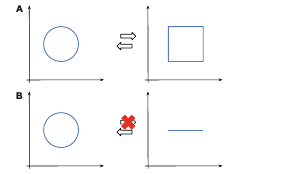

Fig.7 Examples of: (a) homeomorphic spaces, and (b) non-homeomorphic spaces. The red cross indicates it is impossible invert the transformation.

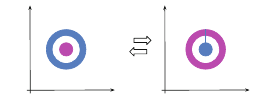
Fig.8 An example of “replacing” a ring (in blue) with a ball (in magenta).

##  Flows for Discrete Random Variables

###  Introduction

While discussing flow-based models in the previous section, we presented them as density estimators, namely, models that represent stochastic dependencies among continuous random variables. We introduced the change of variables formula that helps to express a random variable by transforming it using invertible maps (bijections) $ f $ to a random variable with a known probability density function. Formally, it is defined as follows:

$$
p(x) = p(z = f^{-1}(x)) \left| J_f(z) \right|
$$

where $ J_f(z) $ is the Jacobian of $ f $ at $ z $.

However, there are potential issues with such an approach. First of all, in many problems (e.g., image processing), the considered random variables (objects) are discrete. For instance, images typically take values in $ \{0, 1, \dots, 255\} \subset \mathbb{Z} $. In order to apply flows, we must apply dequantization [10] that results in a lower bound to the original probability distribution.

A continuous space possesses various potential pitfalls. One of them is that if a transformation is a bijection (as in flows), not all continuous deformations are possible. It is tightly connected with topology and, more precisely, homeomorphisms, i.e., a continuous function between topological spaces that has a continuous inverse function, and diffeomorphisms, i.e., invertible functions that map one differentiable manifold to another such that both the function and its inverse are smooth.

It is not crucial to know topology, but a curious reader may take a detour and read on that; it is definitely a fascinating field, and I wish to know more about it!

Anyway, let us consider three examples. Imagine we want to transform a square into a circle (Fig.7a). It is possible to find a homeomorphism (i.e., a bijection) that turns the square into a circle and back. Imagine you have a hammer and an iron square. If you start hitting the square infinitely many times, you can get an iron circle. Then, you can do it "backward" to get the square back. I know, it is unrealistic but hey, we're talking about math here!

However, if we consider a line segment and a circle (Fig. 4.7b), the situation is a bit more complicated. It is possible to transform the line segment into a circle, but not the other way around. Why? Because while transforming the circle to the line segment, it is unclear which point of the circle corresponds to the beginning (or the end) of the line segment. That is why we cannot invert the transformation!

Another example that I really like, and which is closer to the potential issues of continuous flows, is transforming a ring into a ball as in Fig. 4.8. The goal is to replace the blue ring with the magenta ball. In order to make the transformation bijective, while transforming the blue ring in place of the magenta ball, we must ensure that the new magenta "ring" is in fact "broken" so that the new blue "ball" can get inside! Again, why? If the magenta ring is not broken, then we cannot say how the blue ball got inside, which destroys bijectivity! In the language of topology, it is impossible because the two spaces are non-homeomorphic.

#### Fig.7 Examples of:
- (a) homeomorphic spaces
- (b) non-homeomorphic spaces.

The red cross indicates it is impossible to invert the transformation.

#### Fig.8 An example of "replacing" a ring (in blue) with a ball (in magenta).

### Flows for Discrete Random Variables

Now, how does this affect flow-based models? I hope that some of you asked this question, or maybe even imagined possible cases where this might hinder learning flows. In general, I would say it is fine, and we should not look for faults where there are none or almost none. However, if you work with flows that require dequantization, then you can spot cases like the one in Fig. 4.9.

In this simple example, we have two discrete random variables that after uniform dequantization have two regions with equal probability mass and the remaining two regions with zero probability mass [10]. After training a flow-based model, we have a density estimator that assigns nonzero probability mass where the true distribution has zero density! Moreover, the transformation in the flow must be a bijection; therefore, there is a continuity between the two squares (see Fig. 4.9, right).

Where did we see that? Yes, in Fig. 4.8! We must know how to invert the transformation; thus, there must be a "trace" of how the probability mass moves between the regions.

Again, we can ask ourselves if it is bad. Well, I would say not really, but if we think of a case with more random variables, and there is always some little error here and there, this causes a probability mass leakage that could result in a far-from-perfect model. And overall, the model could err in proper probability assignment.

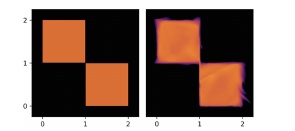
Fig.9 An example of uniformly dequantized discrete random variables (left) and a ﬂow-based model (right). Notice that in these examples, the true distribution assigns equal probability mass to the two regions in orange, and zero probability mass to the remaining two regions (in black). However, the ﬂow-based model assigns probability mass outside the original nonzero probability regions.


#### Fig.9 An example of uniformly dequantized discrete random variables (left) and a flow-based model (right).
Notice that in these examples, the true distribution assigns equal probability mass to the two regions in orange, and zero probability mass to the remaining two regions (in black). However, the flow-based model assigns probability mass outside the original nonzero probability regions.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class FlowModel(nn.Module):
    def __init__(self, num_bins=256, hidden_dim=256):
        super(FlowModel, self).__init__()
        self.num_bins = num_bins
        self.hidden_dim = hidden_dim
        
        # Define the normalizing flow layers
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_bins, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, num_bins)
            ) for _ in range(4)
        ])
        
    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            # Forward pass through the flow layers
            x, ldj = layer(x)  # Log-determinant Jacobian (simplified)
            log_det_jacobian += ldj
        return x, log_det_jacobian
    
    def inverse(self, y):
        # This would typically reverse the flow layers
        for layer in reversed(self.layers):
            y = layer(y)
        return y

def dequantize(x, noise_level=0.1):
    """
    Dequantizes discrete random variables by adding uniform noise.
    """
    return x + torch.rand_like(x).float() * noise_level

def nll_loss(model, x):
    # Dequantize the input data
    x_dequantized = dequantize(x)
    
    # Forward pass through the model
    x_transformed, log_det_jacobian = model(x_dequantized)
    
    # Compute the log-likelihood (negative log-likelihood is the loss)
    log_prob = -0.5 * torch.sum(x_transformed ** 2, dim=1)  # Gaussian assumption
    loss = -torch.mean(log_prob + log_det_jacobian)
    
    return loss

# Initialize the model and optimizer
model = FlowModel(num_bins=256, hidden_dim=256)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Generate some synthetic discrete data
num_samples = 10000
data = torch.randint(0, 256, (num_samples, 1), dtype=torch.float32)  # Random integers between 0 and 255

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    
    # Calculate the negative log-likelihood loss
    loss = nll_loss(model, data)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

# Sampling from the trained flow model
model.eval()
with torch.no_grad():
    sampled_data = model.inverse(torch.randn(1000, 1))  # Sample from standard normal distribution
    
    # Plot the histogram of the sampled data
    plt.hist(sampled_data.numpy(), bins=50, density=True)
    plt.title("Histogram of Sampled Data")
    plt.show()


In [ ]:
import random
import math
import matplotlib.pyplot as plt

class FlowModel:
    def __init__(self, num_bins=256, hidden_dim=256):
        self.num_bins = num_bins
        self.hidden_dim = hidden_dim
        self.layers = []
        
        # Initialize the model's layers
        for _ in range(4):
            self.layers.append(self.create_layer())
    
    def create_layer(self):
        # Each layer will be represented by a random linear transformation matrix for simplicity
        return {'W': [[random.uniform(-1, 1) for _ in range(self.hidden_dim)] for _ in range(self.num_bins)],
                'b': [random.uniform(-1, 1) for _ in range(self.hidden_dim)]}
    
    def apply_layer(self, x, layer):
        # Apply a simple linear transformation followed by ReLU activation
        return [max(0, sum(x_i * layer['W'][i][j] for i, x_i in enumerate(x)) + layer['b'][j]) for j in range(self.hidden_dim)]

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            # Forward pass through the layers
            x = self.apply_layer(x, layer)
        return x, log_det_jacobian
    
    def inverse(self, y):
        for layer in reversed(self.layers):
            # Inverse pass through the layers (simplified for demonstration)
            y = self.apply_layer(y, layer)
        return y

def dequantize(x, noise_level=0.1):
    """
    Dequantizes discrete random variables by adding uniform noise.
    """
    return [xi + random.uniform(0, noise_level) for xi in x]

def nll_loss(model, x):
    # Dequantize the input data
    x_dequantized = dequantize(x)
    
    # Forward pass through the model
    x_transformed, log_det_jacobian = model.forward(x_dequantized)
    
    # Compute the log-likelihood (negative log-likelihood is the loss)
    log_prob = -0.5 * sum(xi ** 2 for xi in x_transformed)  # Gaussian assumption
    loss = -log_prob + log_det_jacobian
    
    return loss

# Initialize the model
model = FlowModel(num_bins=256, hidden_dim=256)

# Generate synthetic discrete data
num_samples = 10000
data = [[random.randint(0, 255)] for _ in range(num_samples)]  # Random integers between 0 and 255

# Training loop
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    
    # Calculate the negative log-likelihood loss for each sample
    for x in data:
        loss = nll_loss(model, x)
        total_loss += loss
    
    average_loss = total_loss / len(data)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {average_loss}")

# Sampling from the trained flow model
sampled_data = []
for _ in range(1000):
    sample = [random.gauss(0, 1)]  # Sample from standard normal distribution
    sampled_data.append(model.inverse(sample))

# Plot the histogram of the sampled data
plt.hist([sample[0] for sample in sampled_data], bins=50, density=True)
plt.title("Histogram of Sampled Data")
plt.show()


Epoch 0/100, Loss: 29085626890.91003


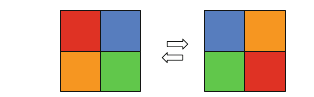
Fig.10 An example of a discrete ﬂow for two binary random variables. Colors represent various probabilities (i.e., the sum of all squares is 1).

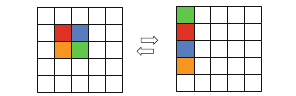

Fig.11 An example of a discrete ﬂow for two binary random variables but in the extended space. Colors represent various probabilities (i.e., the sum of all squares is 1).
## Flows for Discrete Random Variables

##  Flows in $ \mathbb{R} $ or Maybe Rather in $ \mathbb{Z} $?

Before we consider any specific cases and discuss discrete flows, first we need to answer whether there is a change of variables formula for discrete random variables. The answer, fortunately, is **yes**! Let us consider $ x \in X_D $, where $ X $ is a discrete space, e.g., $ X = \{0, 1\} $ or $ X = \mathbb{Z} $. Then the change of variables takes the following form:

$$
p(x) = \pi\left( z_0 = f^{-1}(x) \right)
$$

where $ f $ is an invertible transformation, and $ \pi(\cdot) $ is a base distribution. 

Immediately we can spot a “missing” Jacobian determinant. This is correct! Why? Because now we live in a discrete world where the probability mass is assigned to points that are “shapeless,” and the bijection cannot change the volume. Thus, the Jacobian determinant is always equal to 1! That seems to be good news, isn’t it?

We can take any bijective transformations, and we do not need to bother about the Jacobian. That is obviously true; however, we need to remember that the output of the transformation must still be discrete, i.e., $ z \in X_D $. As a result, we cannot use any arbitrary invertible neural network. 

Let us discuss the **expressivity** of discrete flows. Suppose we have an invertible transformation $ f: X_D \to X_D $. Moreover, assume $ X = \{0, 1\} $. As noted by [27], a discrete flow can only permute probability masses. Since there is no Jacobian (or, rather, the Jacobian determinant is equal to 1), there is no chance to decrease or increase the probability for specific values.

We can think of it like this: the space is the Rubik's cube, and your hands are the flows. If you record your moves, you can always play the video backward, so it is invertible. However, you can only shuffle the colors around! As a result, we do not gain anything by applying the discrete flow, and learning the discrete flow is equivalent to learning the base distribution $ \pi $. 

But, as pointed out by [12], the situation looks different if we consider an **extended space** (or infinite space like $ \mathbb{Z} $). The discrete flow can still only shuffle the probabilities, but now it can reorganize them in such a way that the probabilities can be **factorized**!

In other words, it can help the base distribution to be a product of marginals:

$$
\pi(z) = \prod_{d=1}^D \pi_d(z_d | \theta_d)
$$

and the dependencies among variables are now encoded in the invertible transformations.

An example of this case is presented below:



We refer to [12] for a more thorough discussion with an appropriate lemma. 

This is amazing information! It means that building a flow-based model in the discrete space makes sense.

## Integer Discrete Flows

We now know that it makes sense to work with discrete flows, and they are flexible as long as we use extended spaces or infinite spaces like $ \mathbb{Z} $. However, the question is: **How to formulate an invertible transformation (or rather an invertible neural network) that will output discrete values?**

Hoogeboom et al. [22] proposed focusing on integers, since they can be seen as discretized continuous values. As such, we consider **coupling layers** [7] and modify them accordingly.

Let us remind ourselves the definition of bipartite coupling layers for $ x \in \mathbb{R}^D $:

$$
y_a = x_a
$$

$$
y_b = \exp(s(x_a)) \odot x_b + t(x_a)
$$

where $ s(\cdot) $ and $ t(\cdot) $ are arbitrary neural networks called scaling and transition, respectively.

Considering integer-valued variables, $ x \in \mathbb{Z}^D $ requires modifying this transformation. First, using scaling might be troublesome because multiplying by integers is still possible, but when we invert the transformation, we divide by integers. Dividing an integer by an integer does not necessarily result in an integer. Therefore, we must remove scaling just in case. 

Second, we use an arbitrary neural network for the transition. However, this network must return integers! [22] utilize a relatively simple trick: they say that we can **round** the output of $ t(\cdot) $ to the closest integer. As a result, we add (in the forward pass) or subtract (in the inverse pass) integers from integers, which is perfectly fine (the outcome is still integer-valued).

Eventually, we get the following bipartite coupling layer for integer-valued variables:

$$
y_a = x_a
$$

$$
y_b = \text{round}(t(x_a)) + x_b
$$

This completes the modification for integer-valued transformations in discrete spaces. 

---
**References:**
- Hoogeboom, et al. [22]
- [12] and [27] for further details on discrete flows in extended spaces.


In [ ]:
import random
import math
import matplotlib.pyplot as plt

class DiscreteFlowModel:
    def __init__(self, input_dim=1, hidden_dim=8):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layers = []
        
        # Initialize the model's layers (using random integer-valued weights and biases)
        for _ in range(2):  # Two layers for simplicity
            self.layers.append(self.create_layer())
    
    def create_layer(self):
        # Each layer will consist of a random integer transformation (s and t)
        return {
            's': lambda x: [random.randint(-1, 1) for _ in range(self.input_dim)],  # scaling (just random integers for simplicity)
            't': lambda x: [random.randint(-5, 5) for _ in range(self.input_dim)]  # transition (also random integers)
        }
    
    def apply_layer(self, x, layer):
        # Apply the bipartite coupling layer transformation
        y_a = x[:len(x) // 2]  # Leave the first half unchanged
        y_b = [xi + t for xi, t in zip(x[len(x) // 2:], layer['t'](x))]  # Apply the transition to the second half (with rounding)
        
        # Concatenate the transformed parts
        y = y_a + y_b
        return y
    
    def forward(self, x):
        # Pass through the layers
        for layer in self.layers:
            x = self.apply_layer(x, layer)
        return x
    
    def inverse(self, y):
        # Inverse pass (applying the layers in reverse order)
        for layer in reversed(self.layers):
            y = self.apply_layer(y, layer)
        return y
    
    def sample(self, num_samples=10):
        # Sample from the model by generating random integers (simple approach)
        return [[random.randint(0, 10) for _ in range(self.input_dim)] for _ in range(num_samples)]


# Test the DiscreteFlowModel
def test_discrete_flow():
    model = DiscreteFlowModel(input_dim=4, hidden_dim=8)  # 4-dimensional input, 8 hidden units per layer

    # Generate some synthetic data
    data = [[random.randint(0, 10) for _ in range(4)] for _ in range(100)]

    # Forward pass through the model
    transformed_data = []
    for sample in data:
        transformed_data.append(model.forward(sample))

    # Plot the original vs. transformed data (just for demonstration, plot first dimension)
    plt.hist([sample[0] for sample in data], bins=10, alpha=0.5, label="Original Data")
    plt.hist([transformed[0] for transformed in transformed_data], bins=10, alpha=0.5, label="Transformed Data")
    plt.legend()
    plt.title("Histogram of Original vs. Transformed Data")
    plt.show()

    # Sampling new data points
    sampled_data = model.sample(num_samples=10)
    print(f"Sampled Data: {sampled_data}")

# Run the test
test_discrete_flow()


# Discrete Flow-based Model with Quadripartite Coupling Layer and STE

In this section, we discuss the **quadripartite coupling layer** and its implementation in a discrete flow-based model. We also use the **straight-through estimator (STE)** to handle the rounding operation in the forward pass while maintaining differentiability in the backward pass.

## Straight-Through Estimator (STE) for Rounding

Since rounding is a non-differentiable operation, we use the **straight-through estimator (STE)**, which allows us to compute gradients even with a non-differentiable function like rounding. The STE works by applying the rounding operation during the forward pass and using the original input in the backward pass to compute gradients.

### STE Implementation in PyTorch

```python
import torch

class RoundStraightThrough(torch.autograd.Function):
    """
    Implements the rounding operation with the straight-through estimator.
    """
    @staticmethod
    def forward(ctx, input):
        """
        Forward pass: applies rounding in the forward pass.
        """
        rounded = torch.round(input)  # Round the input
        return rounded

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass: passes the gradient through as-is (STE).
        """
        grad_input = grad_output.clone()  # Gradient is passed through without modification
        return grad_input

    
    # Proposition 4.1 and Quadripartite Coupling Layer Transformation

## Proposition 4.1



Let $ x, y \in X $. If binary transformations $ \circ $ and $ \sqsubset $ have inverses $ \bullet $ and $ \nabla $, respectively, and $ g_2, \dots, g_D $ and $ f_1, \dots, f_D $ are arbitrary functions, where $ g_i: X_{1:i-1} \rightarrow X_i $, and $ f_i: X_{1:i-1} \times X_{i+1:D} \rightarrow X_i $, then the following transformation from $ x $ to $ y $ is invertible:

$$
y_1 = x_1 \circ f_1(\emptyset, x_{2:D})
$$
$$
y_2 = (g_2(y_1) \sqsubset x_2) \circ f_2(y_1, x_{3:D})
$$
$$
\vdots
$$
$$
y_d = (g_d(y_{1:d-1}) \sqsubset x_d) \circ f_d(y_{1:d-1}, x_{d+1:D})
$$
$$
\vdots
$$
$$
y_D = (g_D(y_{1:D-1}) \sqsubset x_D) \circ f_D(y_{1:D-1}, \emptyset)
$$

### Proof of Invertibility

To reverse $ y $ to $ x $, we start from the last element $ y_D $ and obtain:

$$
x_D = g_D(y_{1:D-1}) \nabla (y_D \bullet f_D(y_{1:D-1}, \emptyset))
$$

Then, we proceed with the next expressions in decreasing order (from $ D-1 $ to 1) to eventually obtain:

$$
x_{D-1} = g_{D-1}(y_{1:D-2}) \nabla (y_{D-1} \bullet f_{D-1}(y_{1:D-2}, x_D))
$$
$$
\vdots
$$
$$
x_2 = g_2(y_1) \nabla (y_2 \bullet f_2(y_1, x_{3:D}))
$$
$$
x_1 = y_1 \bullet f_1(\emptyset, x_{2:D})
$$

This completes the proof of the invertibility of the transformation. $ \square $

## Quadripartite Coupling Layer Transformation

For instance, we can divide $ x $ into four parts, $ x = [x_a, x_b, x_c, x_d] $, and the following transformation (a quadripartite coupling layer) is invertible:

$$
y_a = x_a + \lfloor t(x_b, x_c, x_d) \rfloor
$$
$$
y_b = x_b + \lfloor t(y_a, x_c, x_d) \rfloor
$$
$$
y_c = x_c + \lfloor t(y_a, y_b, x_d) \rfloor
$$
$$
y_d = x_d + \lfloor t(y_a, y_b, y_c) \rfloor
$$

This new invertible transformation can be seen as a form of **autoregressive processing**, since $ y_a $ is used to calculate $ y_b $, and then both $ y_a $ and $ y_b $ are used for calculating $ y_c $, and so on. Thus, each transformation builds upon the previous one, making this a **sequential transformation**.


In [ ]:
import torch
import torch.nn as nn


# Straight-Through Estimator (STE) for the Rounding Operator
class RoundStraightThrough(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        rounded = torch.round(input)  # Round the input during the forward pass
        return rounded
    
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()  # Pass the gradient through unchanged during the backward pass
        return grad_input


# Transition Network (a simple MLP) for computing the transformation
class TransitionNetwork(nn.Module):
    def __init__(self, input_dim):
        super(TransitionNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output one scalar for the transformation

    def forward(self, *inputs):
        # Concatenate inputs along the feature dimension
        x = torch.cat(inputs, dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        t = self.fc3(x)
        return t


# Quadripartite Coupling Layer Implementation
class QuadripartiteCouplingLayer(nn.Module):
    def __init__(self, transition_network):
        super(QuadripartiteCouplingLayer, self).__init__()
        self.transition_network = transition_network  # Neural network for the transition

    def forward(self, x):
        # Split x into four parts
        xa, xb, xc, xd = torch.chunk(x, 4, dim=-1)

        # Apply the transformations
        ta = self.transition_network(xb, xc, xd)
        ya = xa + RoundStraightThrough.apply(ta)  # Apply rounding with STE

        tb = self.transition_network(ya, xc, xd)
        yb = xb + RoundStraightThrough.apply(tb)

        tc = self.transition_network(ya, yb, xd)
        yc = xc + RoundStraightThrough.apply(tc)

        td = self.transition_network(ya, yb, yc)
        yd = xd + RoundStraightThrough.apply(td)

        # Concatenate the transformed parts
        y = torch.cat([ya, yb, yc, yd], dim=-1)
        return y


# Example Usage
if __name__ == "__main__":
    # Example input (batch_size=2, feature_dim=4)
    x = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=torch.float32)

    # Define transition network
    transition_network = TransitionNetwork(input_dim=3)  # 3 inputs for each transition function

    # Define coupling layer
    coupling_layer = QuadripartiteCouplingLayer(transition_network)

    # Apply coupling layer
    y = coupling_layer(x)
    print("Transformed y:", y)


## Integer Discrete Flows (IDF) Model

In this section, we define the Integer Discrete Flow (IDF) model using two types of coupling layers. The first option is a bipartite coupling layer, as introduced in Hoogeboom et al. (2019), and the second option is a new coupling layer with four parts, as proposed in Tomczak (2021). We will focus on the second option, which explicitly divides the transformation into four parts.

### Discretized Logistic Distribution

The base distribution in the model is based on a discretized logistic distribution, defined as follows:

$$
\pi(z) = \sigma\left(\frac{z + 0.5 - \mu}{\nu}\right) - \sigma\left(\frac{z - 0.5 - \mu}{\nu}\right)
$$

where $\mu \in \mathbb{R}$ is the mean and $\nu > 0$ is the scale. The function $\sigma(\cdot)$ is the sigmoid function, and the discretized logistic distribution represents the probability mass in bins of length 1. This distribution is used to model integer-valued flows, and we can extend it to a mixture of discretized logistic distributions for better performance.

### Logarithm of the Discretized Logistic Distribution

We define the logarithm of the discretized logistic distribution as follows:

$$
\log p(x) = \log \left( \sigma\left(\frac{z + 0.5 - \mu}{\nu}\right) - \sigma\left(\frac{z - 0.5 - \mu}{\nu}\right) \right)
$$

This can be implemented in Python as:

```python
import torch
import torch.nn.functional as F

def log_integer_probability(x, mean, logscale):
    scale = torch.exp(logscale)
    logp = log_min_exp(
        F.logsigmoid((x + 0.5 - mean) / scale),
        F.logsigmoid((x - 0.5 - mean) / scale)
    )
    return logp
class IDF(nn.Module):
    def __init__(self, netts, num_flows, D=2):
        super(IDF, self).__init__()
        print('IDF by JT.')
        # Define the number of layers and the flow network
        self.num_flows = num_flows
        self.D = D  # Number of variables
        self.netts = netts  # Network for the transformations
        self.flows = nn.ModuleList([QuadripartiteCouplingLayer(self.netts) for _ in range(self.num_flows)])

    def forward(self, x):
        for flow in self.flows:
            x = flow(x)
        return x
# Example of defining and using the IDF model
if __name__ == "__main__":
    # Define the transition network
    transition_network = TransitionNetwork(input_dim=3)
    
    # Define the IDF model
    num_flows = 2  # Number of flows to apply
    idf_model = IDF(netts=transition_network, num_flows=num_flows, D=4)
    
    # Example input (batch_size=2, feature_dim=4)
    x = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=torch.float32)
    
    # Apply IDF model
    y = idf_model(x)
    print("Transformed output y:", y)


## Integer Discrete Flows (IDF): Full Implementation

This section provides the complete implementation of the Integer Discrete Flows (IDF) model. Two options for coupling layers are considered:
1. **Option 1**: The bipartite coupling layer as proposed by Hoogeboom et al. (2019).
2. **Option 2**: The quadripartite coupling layer as introduced by Tomczak (2021), which splits the input into four parts.

### IDF Class Implementation

The class includes:
1. Initialization of parameters and networks.
2. Coupling layers for forward and inverse transformations.
3. Permutation layers for variable reordering.
4. Methods for sampling and calculating log-probability.

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class IDF(nn.Module):
    def __init__(self, netts, num_flows, D=2):
        super(IDF, self).__init__()
        print('IDF Initialized.')

        # Choose between one translation network or four networks
        if len(netts) == 1:
            self.t = nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.idf_git = 1
        elif len(netts) == 4:
            self.t_a = nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.t_b = nn.ModuleList([netts[1]() for _ in range(num_flows)])
            self.t_c = nn.ModuleList([netts[2]() for _ in range(num_flows)])
            self.t_d = nn.ModuleList([netts[3]() for _ in range(num_flows)])
            self.idf_git = 4
        else:
            raise ValueError('Provide either 1 or 4 translation networks.')

        self.num_flows = num_flows
        self.round = RoundStraightThrough.apply  # Rounding operator

        # Parameters for base distribution (mean and log-scale)
        self.mean = nn.Parameter(torch.zeros(1, D))
        self.logscale = nn.Parameter(torch.ones(1, D))

        self.D = D

    def coupling(self, x, index, forward=True):
        if self.idf_git == 1:
            xa, xb = torch.chunk(x, 2, dim=1)
            if forward:
                yb = xb + self.round(self.t[index](xa))
            else:
                yb = xb - self.round(self.t[index](xa))
            return torch.cat((xa, yb), dim=1)

        elif self.idf_git == 4:
            xa, xb, xc, xd = torch.chunk(x, 4, dim=1)
            if forward:
                ya = xa + self.round(self.t_a[index](torch.cat((xb, xc, xd), dim=1)))
                yb = xb + self.round(self.t_b[index](torch.cat((ya, xc, xd), dim=1)))
                yc = xc + self.round(self.t_c[index](torch.cat((ya, yb, xd), dim=1)))
                yd = xd + self.round(self.t_d[index](torch.cat((ya, yb, yc), dim=1)))
            else:
                yd = xd - self.round(self.t_d[index](torch.cat((xa, xb, xc), dim=1)))
                yc = xc - self.round(self.t_c[index](torch.cat((xa, xb, yd), dim=1)))
                yb = xb - self.round(self.t_b[index](torch.cat((xa, yc, yd), dim=1)))
                ya = xa - self.round(self.t_a[index](torch.cat((yb, yc, yd), dim=1)))
            return torch.cat((ya, yb, yc, yd), dim=1)

    def permute(self, x):
        return x.flip(1)  # Simple flip operation for permutation

    def f(self, x):
        z = x
        for i in range(self.num_flows):
            z = self.coupling(z, i, forward=True)
            z = self.permute(z)
        return z

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x = self.coupling(x, i, forward=False)
        return x

    def forward(self, x, reduction='avg'):
        z = self.f(x)
        log_p = -self.log_prior(z)
        return log_p.mean() if reduction == 'avg' else log_p.sum()

    def sample(self, batchSize, intMax=100):
        z = self.prior_sample(batchSize=batchSize, D=self.D, intMax=intMax)
        x = self.f_inv(z)
        return x.view(batchSize, 1, self.D)

    def log_prior(self, x):
        log_p = log_integer_probability(x, self.mean, self.logscale)
        return log_p.sum(1)

    def prior_sample(self, batchSize, D=2):
        y = torch.rand(batchSize, self.D)
        x = torch.exp(self.logscale) * torch.log(y / (1. - y)) + self.mean
        return torch.round(x)
D = 4  # Number of features
M = 128  # Hidden layer size
num_flows = 8  # Number of transformations

# Option 1: Single network
if idf_git == 1:
    nett = lambda: nn.Sequential(
        nn.Linear(D // 2, M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 2)
    )
    netts = [nett]

# Option 2: Four networks
elif idf_git == 4:
    nett_a = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 4)
    )
    nett_b = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 4)
    )
    nett_c = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 4)
    )
    nett_d = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 4)
    )
    netts = [nett_a, nett_b, nett_c, nett_d]

# Initialize IDF model
model = IDF(netts, num_flows, D=D)
from torchinfo import summary
summary(model, input_data=torch.zeros(1, D), show_input=False)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Function
import torch

def log_integer_probability(x, mean, logscale):
    """
    Calculate the log probability of x under a logistic distribution.
    Args:
        x: Input tensor.
        mean: Mean of the distribution.
        logscale: Log-scale of the distribution.
    Returns:
        Log-probabilities for each element in x.
    """
    scale = torch.exp(logscale)
    z = (x - mean) / scale
    log_p = -z - 2 * torch.log(1 + torch.exp(-z)) - logscale
    return log_p

# Define RoundStraightThrough
class RoundStraightThrough(Function):
    @staticmethod
    def forward(ctx, input):
        return torch.round(input)  # Forward pass uses the standard rounding function

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through estimator: pass gradients unchanged
        return grad_output

# Use it in your IDF model

class IDF(nn.Module):
    def __init__(self, netts, num_flows, D=2):
        super(IDF, self).__init__()
        print('IDF Initialized.')

        # Choose between one translation network or four networks
        if len(netts) == 1:
            self.t = nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.idf_git = 1
        elif len(netts) == 4:
            self.t_a = nn.ModuleList([netts[0]() for _ in range(num_flows)])
            self.t_b = nn.ModuleList([netts[1]() for _ in range(num_flows)])
            self.t_c = nn.ModuleList([netts[2]() for _ in range(num_flows)])
            self.t_d = nn.ModuleList([netts[3]() for _ in range(num_flows)])
            self.idf_git = 4
        else:
            raise ValueError('Provide either 1 or 4 translation networks.')

        self.num_flows = num_flows
        self.round = RoundStraightThrough.apply  # Rounding operator

        # Parameters for base distribution (mean and log-scale)
        self.mean = nn.Parameter(torch.zeros(1, D))
        self.logscale = nn.Parameter(torch.ones(1, D))

        self.D = D

    def coupling(self, x, index, forward=True):
        if self.idf_git == 1:
            xa, xb = torch.chunk(x, 2, dim=1)
            if forward:
                yb = xb + self.round(self.t[index](xa))
            else:
                yb = xb - self.round(self.t[index](xa))
            return torch.cat((xa, yb), dim=1)

        elif self.idf_git == 4:
            xa, xb, xc, xd = torch.chunk(x, 4, dim=1)
            if forward:
                ya = xa + self.round(self.t_a[index](torch.cat((xb, xc, xd), dim=1)))
                yb = xb + self.round(self.t_b[index](torch.cat((ya, xc, xd), dim=1)))
                yc = xc + self.round(self.t_c[index](torch.cat((ya, yb, xd), dim=1)))
                yd = xd + self.round(self.t_d[index](torch.cat((ya, yb, yc), dim=1)))
            else:
                yd = xd - self.round(self.t_d[index](torch.cat((xa, xb, xc), dim=1)))
                yc = xc - self.round(self.t_c[index](torch.cat((xa, xb, yd), dim=1)))
                yb = xb - self.round(self.t_b[index](torch.cat((xa, yc, yd), dim=1)))
                ya = xa - self.round(self.t_a[index](torch.cat((yb, yc, yd), dim=1)))
            return torch.cat((ya, yb, yc, yd), dim=1)

    def permute(self, x):
        return x.flip(1)  # Simple flip operation for permutation

    def f(self, x):
        z = x
        for i in range(self.num_flows):
            z = self.coupling(z, i, forward=True)
            z = self.permute(z)
        return z

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x = self.coupling(x, i, forward=False)
        return x

    def forward(self, x, reduction='avg'):
        z = self.f(x)
        log_p = -self.log_prior(z)
        return log_p.mean() if reduction == 'avg' else log_p.sum()

    def sample(self, batchSize, intMax=100):
        z = self.prior_sample(batchSize=batchSize, D=self.D, intMax=intMax)
        x = self.f_inv(z)
        return x.view(batchSize, 1, self.D)

    def log_prior(self, x):
        log_p = log_integer_probability(x, self.mean, self.logscale)
        return log_p.sum(1)

    def prior_sample(self, batchSize, D=2):
        y = torch.rand(batchSize, self.D)
        x = torch.exp(self.logscale) * torch.log(y / (1. - y)) + self.mean
        return torch.round(x)
D = 4  # Number of features
M = 128  # Hidden layer size
num_flows = 8  # Number of transformations

# Define `idf_git` to choose the coupling layer configuration
idf_git = 1  # Set to 1 for bipartite, 4 for quadripartite

# Option 1: Single network
if idf_git == 1:
    nett = lambda: nn.Sequential(
        nn.Linear(D // 2, M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 2)
    )
    netts = [nett]

# Option 2: Four networks
elif idf_git == 4:
    nett_a = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 4)
    )
    nett_b = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 4)
    )
    nett_c = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 4)
    )
    nett_d = lambda: nn.Sequential(
        nn.Linear(3 * (D // 4), M), nn.LeakyReLU(),
        nn.Linear(M, M), nn.LeakyReLU(),
        nn.Linear(M, D // 4)
    )
    netts = [nett_a, nett_b, nett_c, nett_d]

# Initialize IDF model
model = IDF(netts, num_flows, D=D)

# Initialize IDF model
model = IDF(netts, num_flows, D=D)
from torchinfo import summary

# Example usage
#summary(model, input_data=torch.zeros(1, D), show_input=False)
test_input = torch.zeros(1, D)  # Replace D with your input dimension
output = model(test_input)
print(output.shape)

IDF Initialized.
IDF Initialized.
torch.Size([])
